In [17]:
## Libraries
import glob
from multiprocessing import cpu_count
import os
import sys
import time

## 3rd party
from gensim.models import Word2Vec
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image, ImageFilter
import torch
import torch.nn as nn
from torch.utils.data import DataLoader

_path = ".."
if _path not in sys.path:
    sys.path.append(_path)
from lib.dataset import TextArtDataLoader, AlignCollate, ImageBatchSampler
from lib.config import Config
from lib.arch import Generator, Discriminator

%reload_ext autoreload
%autoreload 2

In [3]:
DATA_DIR = 'united'

In [20]:
BATCH_SIZE = 2
# N_WORKERS = cpu_count() - 1
N_WORKERS = 0
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
N_EPOCHS = 10
LR_G = 1e-4
LR_D = 1e-4
WEIGHT_DECAY = 1e-4

CONFIG = Config()

In [10]:
train_dataset = TextArtDataLoader(DATA_DIR, CONFIG, mode='train')
val_dataset = TextArtDataLoader(DATA_DIR, CONFIG, mode='val')
test_dataset = TextArtDataLoader(DATA_DIR, CONFIG, mode='test')

train_align_collate = AlignCollate(CONFIG, 'train')
val_align_collate = AlignCollate(CONFIG, 'val')

train_batch_sampler = ImageBatchSampler(DATA_DIR, CONFIG, mode='train')
val_batch_sampler = ImageBatchSampler(DATA_DIR, CONFIG, mode='val')

train_loader = DataLoader(train_dataset,
                          batch_size=BATCH_SIZE,
                          shuffle=False,
                          num_workers=N_WORKERS,
                          pin_memory=True,
                          collate_fn=train_align_collate,
                          sampler=train_batch_sampler,
                         )
val_loader = DataLoader(val_dataset,
                          batch_size=BATCH_SIZE,
                          shuffle=False,
                          num_workers=N_WORKERS,
                          pin_memory=True,
                          collate_fn=val_align_collate,
                          sampler=val_batch_sampler
                         )
test_loader = DataLoader(test_dataset,
                          batch_size=BATCH_SIZE,
                          shuffle=False,
                          num_workers=N_WORKERS,
                          pin_memory=True,
                          collate_fn=None,
                         )

IMAGE: torch.Size([2, 3, 64, 64])
WV: torch.Size([2, 8, 1536])
Fake WV: torch.Size([2, 8, 1536])
WVs
portrait/1.000 realism/1.000 male/1.000 maurit/1.000 expressionism/1.000 expressionism/1.000 people/1.000 romanticism/1.000 
portrait/1.000 analytical/1.000 cubism/1.000 male/1.000 courbet/1.000 karl/1.000 estaque/1.000 portrait/1.000 

Fake WVs
arch/1.000 feature/1.000 pine/1.000 marking/1.000 journal/1.000 otter/1.000 sand/1.000 patch/1.000 
real/1.000 badass/1.000 terra/1.000 bolt/1.000 ethereal/1.000 necklace/1.000 mandalorian/1.000 real/1.000 


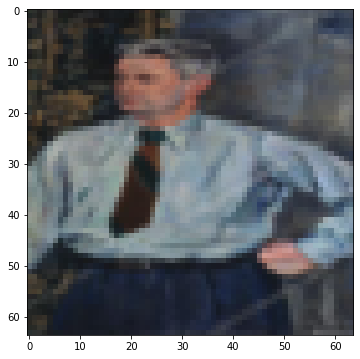

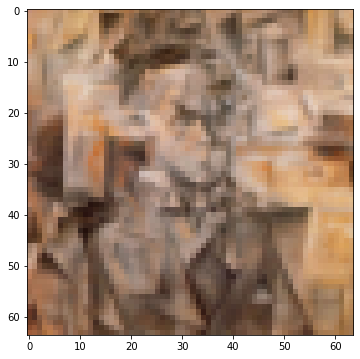

In [21]:
for i, (image, wv_tensor, fake_wv_tensor) in enumerate(train_loader):
    print("IMAGE:", image.shape)
    print("WV:", wv_tensor.shape)
    print("Fake WV:", fake_wv_tensor.shape)
    
    print("WVs")
    for wvs in wv_tensor:
        for wv in wvs:
            wv = np.array(wv)
            word, prob = train_loader.dataset.word2vec_model.wv.similar_by_vector(wv)[0]
            print("{}/{:.3f}".format(word, prob), end=' ')
        print()
    
    print("\nFake WVs")
    for fake_wvs in fake_wv_tensor:
        for fake_wv in fake_wvs:
            fake_wv = np.array(fake_wv)
            fake_word, prob = train_loader.dataset.word2vec_model.wv.similar_by_vector(fake_wv)[0]
            print("{}/{:.3f}".format(fake_word, prob), end=' ')
        print()
    
    images = np.array(image)
    for img in images:
        img = img.transpose(1, 2, 0)
        plt.figure(figsize=(6, 6))
        plt.imshow(img)
        plt.show()
    break

In [30]:
wv_tensor.shape

torch.Size([2, 8, 1536])

In [38]:
images = torch.Tensor(images)
images.shape

torch.Size([2, 3, 64, 64])

In [42]:
r = wv_tensor.reshape(images.shape)
r.shape

torch.Size([2, 3, 64, 64])

In [44]:
torch.cat((images, r), 1).shape

torch.Size([2, 6, 64, 64])

In [22]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

## Generator

In [24]:
G = Generator(CONFIG).to(DEVICE)
G.apply(weights_init)

Generator(
  (fc): Sequential(
    (0): Linear(in_features=2000, out_features=8192, bias=False)
    (1): BatchNorm1d(8192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
  )
  (upsample1): Sequential(
    (0): Upsample(scale_factor=2.0, mode=nearest)
    (1): Conv2d(512, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU(inplace)
  )
  (upsample2): Sequential(
    (0): Upsample(scale_factor=2.0, mode=nearest)
    (1): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU(inplace)
  )
  (upsample3): Sequential(
    (0): Upsample(scale_factor=2.0, mode=nearest)
    (1): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affin

## Discriminator

In [25]:
D = Discriminator(CONFIG).to(DEVICE)
D.apply(weights_init)

Discriminator(
  (conv): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace)
  )
  (get_cond_logits): DiscriminatorLogits(
    (outlogits): Sequential(
      (0): Conv2d(576, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1

## Loss and optimizers

In [ ]:
data_loader = train_loader

optimizer_d = torch.optim.Adam(D.parameters(), lr=LR_D, weight_decay=WEIGHT_DECAY)
optimizer_g = torch.optim.Adam(G.parameters(), lr=LR_G, weight_decay=WEIGHT_DECAY)

loss = nn.BCELoss().to(DEVICE)
loss_ls = lambda x, y: 0.5 * torch.mean((x - y) ** 2)
loss_ms = nn.MSELoss().to(DEVICE)

In [ ]:
G.train()
D.train()

for epoch in range(N_EPOCHS):
    epoch_start = time.time()
    total_g_loss = 0.0
    total_d_loss = 0.0
    
    for i, (images, word_vectors_tensor) in enumerate(data_loader):

        batch_size = images.size()[0]
        
        real_label = torch.full((batch_size,), 1.0, device=DEVICE)
        fake_label = torch.full((batch_size,), 0.0, device=DEVICE)

        images = images.to(DEVICE)
        word_vectors_tensor = word_vectors_tensor.to(DEVICE)
        word_sequence = word_vectors_tensor[:, 0, :].unsqueeze(2).unsqueeze(3)
        
        # Discriminator pass for real
        D.zero_grad()
        output_real = D(images).view(-1)
        loss_real = loss(output_real, real_label)
        loss_real.backward(retain_graph=False)
        
        # Discriminator pass for fake
        fake = G(word_sequence)
        output_fake = D(fake.detach()).view(-1)
        loss_fake = loss(output_fake, fake_label)
        loss_fake.backward(retain_graph=False)
        loss_d = loss_real + loss_fake
        
        # Discriminator update
        optimizer_d.zero_grad()
        optimizer_d.step()

        # Generator pass
        G.zero_grad()
        output_fake = D(fake).view(-1)
        loss_g = loss(output_fake, real_label)
        loss_g.backward(retain_graph=False)

        # Generator backward pass
        optimizer_g.zero_grad()
        optimizer_g.step()
        
        # Update total loss
        total_g_loss += loss_g.item()
        total_d_loss += loss_d.item()

        # Print logs
        if i % 20 == 0:
            print('[{0:3d}/{1}] {2:3d}/{3} loss_g: {4:.4f} | loss_d: {5:4f}'
                .format(epoch + 1, N_EPOCHS, i + 1, len(data_loader), loss_g.item(), loss_d.item()))
            
    print("Epoch time: {}".format(time.time() - epoch_start))
            
    break
            
    
#     # Save your model weights
#     if (epoch + 1) % 5 == 0:
#         save_dict = {
#             'g':G.state_dict(), 
#             'g_optim':optimizer_g.state_dict(),
#             'd': D.state_dict(),
#             'd_optim': optimizer_d.state_dict()
#         }
#         torch.save(save_dict, os.path.join(MODEL_PATH, 'checkpoint_{}.pth'.format(epoch + 1)))
        
#     # Merge noisy input, ground truth and network output so that you can compare your results side by side
#     out = torch.cat([img, fake], dim=2).detach().cpu().clamp(0.0, 1.0)
#     vutils.save_image(out, os.path.join(OUTPUT_PATH, "{}_{}.png".format(epoch, i)), normalize=True)
    
#     # Calculate avarage loss for the current epoch
#     avg_g_loss = total_g_loss / len(data_loader)
#     avg_d_loss = total_d_loss / len(data_loader)
#     print('Epoch[{}] Training Loss G: {:4f} | D: {:4f}'.format(epoch + 1, avg_g_loss, avg_d_loss))
    
#     cache_train_g.append(avg_g_loss)
#     cache_train_d.append(avg_d_loss)